# Лабораторная работа "Численное интегрирование"

В этой лабораторной работе мы выполним численное интегрирование выбранной функции.

Вспомогательный код для вычисления и рисования графиков:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

class GridFunction:
    def __init__(self, a, b, h):
        self.n = int((b - a) / h)
        self.n += (self.n % 2 == 0)
        
        self.a = a
        self.b = a + h * (self.n - 1)
        self.h = h

        self.x = np.zeros(self.n)
        self.y = np.zeros(self.n)
        for i in range(self.n):
            self.x[i] = a + self.h * i

    def calc(self, func):
        self.f = func
        for i in range(len(self.x)):
            self.y[i] = func(self.x[i])

    def plot(self, marker = '', label = '', title_str = ''):
        fig, self.ax = plt.subplots(figsize=(9, 6))

        if label == '':
            self.ax.plot(self.x, self.y, marker)
        else:
            self.ax.plot(self.x, self.y, marker, label = label)
            self.ax.legend()

        self.ax.set(xlabel='x', ylabel='y', title=title_str)
        self.ax.grid()

class IntegralError(GridFunction):
    def __init__(self, begin_h, end_h, step_h, f, F):
        super().__init__(begin_h, end_h, step_h)
        self.f = f
        self.F = F

    def plot(self, title_str = ''):
        super().plot(title_str = title_str)
        self.ax.set(xlabel='ln(h)', ylabel='ln(Err)')
        k, b = np.polyfit(self.x, self.y, 1)

        label_str = '{:.2f}*x + {:.2f}'.format(k, b)
        self.ax.plot(self.x, k * self.x + b, 'r-', linewidth=0.5, label=label_str)
        self.ax.legend()

    def calc(self, a, b, method, logarithm = False):
        for i in range(self.n):
            gf = GridFunction(a, b, self.x[i])
            gf.calc(self.f)
            sum = method(gf)

            self.y[i] = m.fabs(self.F(gf.b) - self.F(gf.a) - sum)

            if logarithm:
                self.x[i] = m.log(self.x[i])
                self.y[i] = m.log(self.y[i])

def riemann_left(gf, step = 1):
    sum = 0
    for i in range(0, gf.n - 1, step):
        sum += gf.y[i]
    return sum * gf.h * step

def riemann_right(gf):
    sum = 0
    for i in range(1, gf.n):
        sum += gf.y[i]
    return sum * gf.h

def riemann_central(gf):
    sum = (gf.y[0] + gf.y[-1]) / 2
    for i in range(1, gf.n - 1):
        sum += gf.y[i]
    return sum * gf.h

def trapezoidal(gf, step = 1):
    sum = 0
    for i in range(0, gf.n - 1, step):
        sum += gf.y[i] + gf.y[i + step]
    return sum * gf.h * step / 2

def simpson(gf):
    sum = 0
    for i in range(1, gf.n - 1, 2):
        sum += gf.y[i - 1] + 4 * gf.y[i] + gf.y[i + 1]
    return sum * gf.h / 3

def runge(method, gf, p):
    A = method(gf)
    Ar = method(gf, 2)
    return A + (A - Ar) / (2 ** p - 1)

В качастве функции возьмем $$f(x) = xcos(x)$$
на отрезке $[0, 2]$

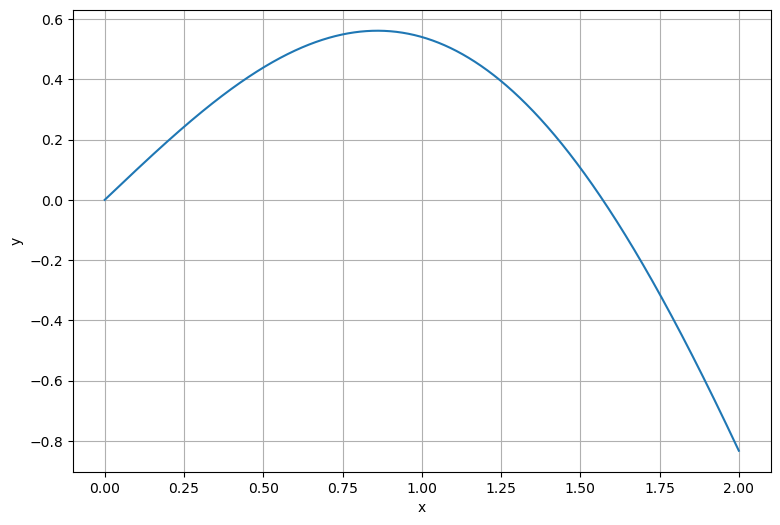

In [3]:
my_f = lambda x: m.cos(x) * x
my_F = lambda x: m.sin(x) * x + m.cos(x)

a, b = 0, 2

gf = GridFunction(0, 2, 0.001)
gf.calc(my_f)
gf.plot()

Посчитаем погрешности и выведем график для интегралов с разными порядками вычислений.
Проведем линейную аппроксимацию и найдем коэффициент наклона прямой.

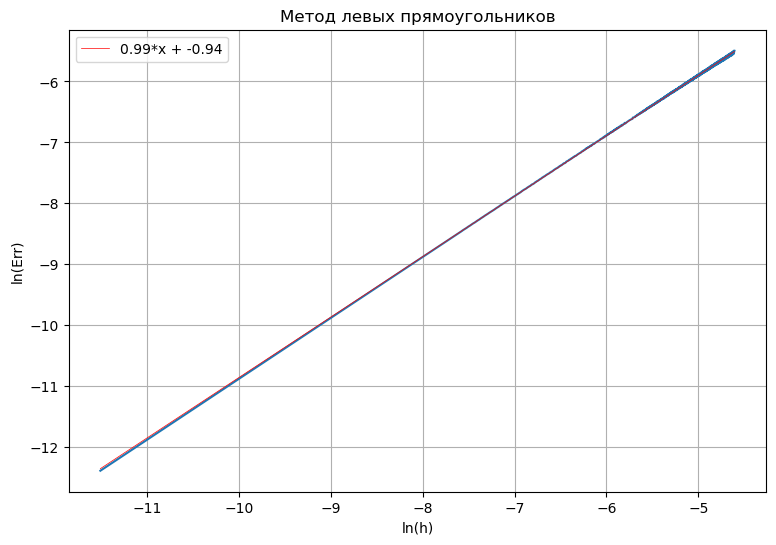

In [552]:
err = IntegralError(0.00001, 0.01, 0.00001, my_f, my_F)
err.calc(a, b, riemann_left, True)
err.plot('Метод левых прямоугольников')

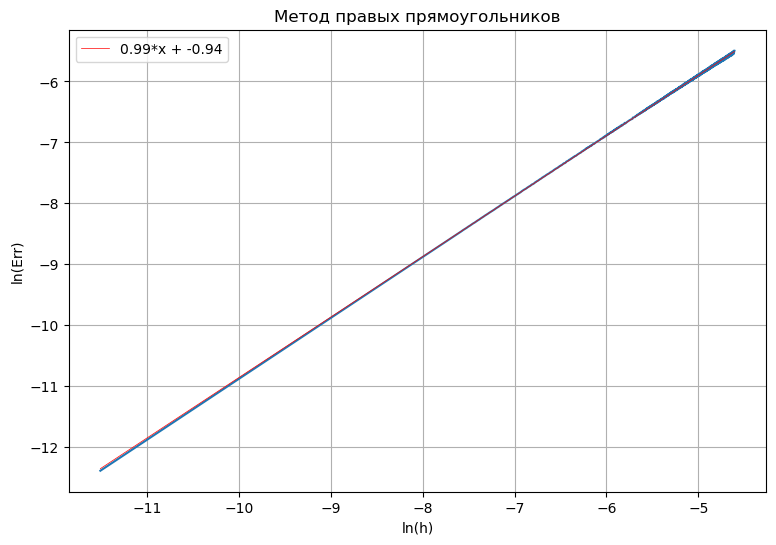

In [590]:
err = IntegralError(0.00001, 0.01, 0.00001, my_f, my_F)
err.calc(a, b, riemann_right, True)
err.plot('Метод правых прямоугольников')

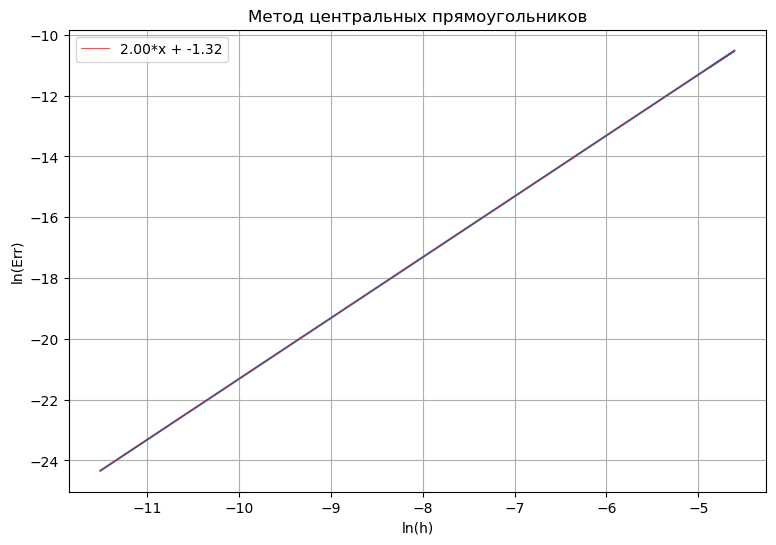

In [554]:
err = IntegralError(0.00001, 0.01, 0.00001, my_f, my_F)
err.calc(a, b, riemann_central, True)
err.plot('Метод центральных прямоугольников')

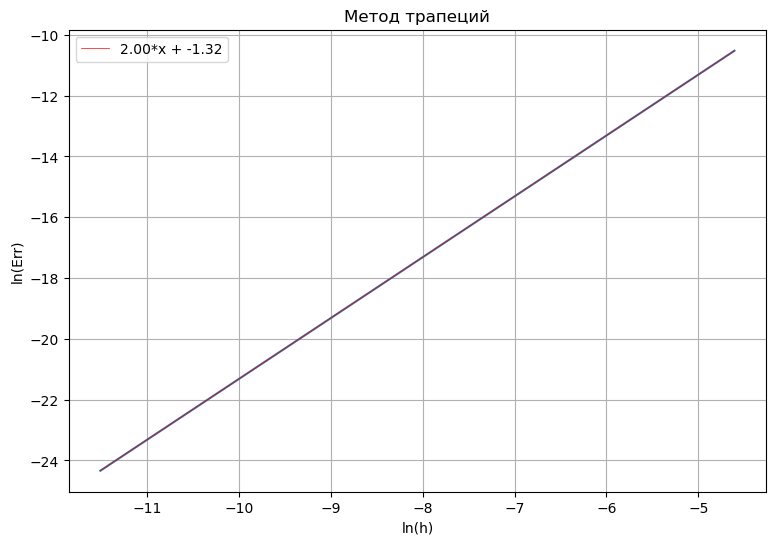

In [555]:
err = IntegralError(0.00001, 0.01, 0.00001, my_f, my_F)
err.calc(a, b, trapezoidal, True)
err.plot('Метод трапеций')

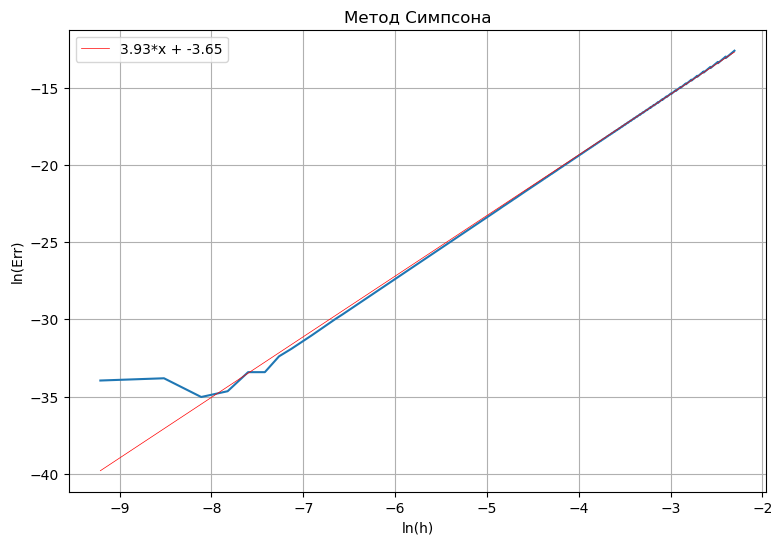

In [530]:
err = IntegralError(0.0001, 0.1, 0.0001, my_f, my_F)
err.calc(a, b, simpson, True)
err.plot('Метод Симпсона')

### Правило Рунге

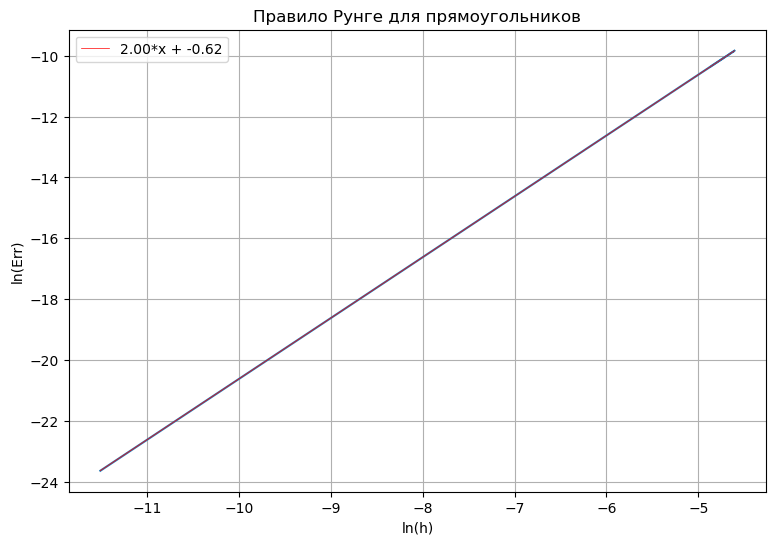

In [605]:
func = lambda gf: runge(riemann_left, gf, 1)

err = IntegralError(0.00001, 0.01, 0.00001, my_f, my_F)
err.calc(a, b, func, True)
err.plot('Правило Рунге для прямоугольников')

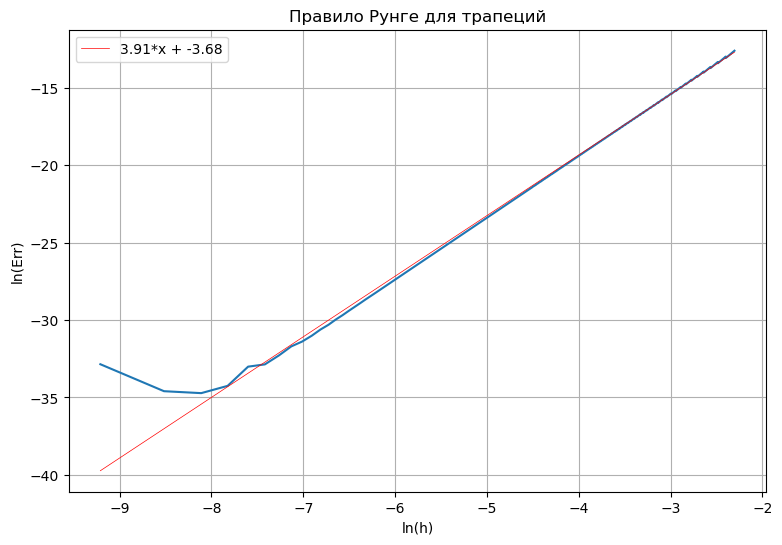

In [624]:
func = lambda gf: runge(trapezoidal, gf, 2)

err = IntegralError(0.0001, 0.1, 0.0001, my_f, my_F)
err.calc(a, b, func, True)
err.plot('Правило Рунге для трапеций')

### Вычисление несобственных интегралов

В качастве функции возьмем $$f(x) = e^{-x^2}$$
на $[0, \infty)$. Посчитаем интеграл с погрешностью $\epsilon = 0.0001$. $\\ $
$\int_{0}^{\infty} = \int_{0}^{A} + \int_{A}^{\infty} \\ $
$\int_{A}^{\infty}e^{-x^2}dx < \int_{A}^{\infty}e^{-x}dx < \frac{\epsilon}{2} \\ $
$A > -ln(\frac{\epsilon}{2}) = 10 \\ $
$|\int_{0}^{A}e^{-x^2}dx - I| < \frac{h^2A}{2}max|(e^{-x^2})''| < \frac{\epsilon}{2} \\ $
$h < \sqrt{\frac{\epsilon e}{4A}} = 0.002$

In [10]:
my_f = lambda x: m.exp(-x * x)

a, b = 0, 10

gf = GridFunction(a, b, 2)
gf.calc(my_f)
A = trapezoidal(gf)
T = m.sqrt(m.pi) / 2
print("Вычисленное значение =", A)
print("Истинное значение =", T)
print("Погрешность =", m.fabs(A - T))

Вычисленное значение = 1.0366315028478184
Истинное значение = 0.8862269254527579
Погрешность = 0.1504045773950604
